Folder structure created!
Merged CSV saved: /content/ds_siddhi/csv_files/merged_trader_sentiment.csv
Performance summary CSV saved: /content/ds_siddhi/csv_files/performance_summary.csv


/tmp/ipython-input-546865180.py:66: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


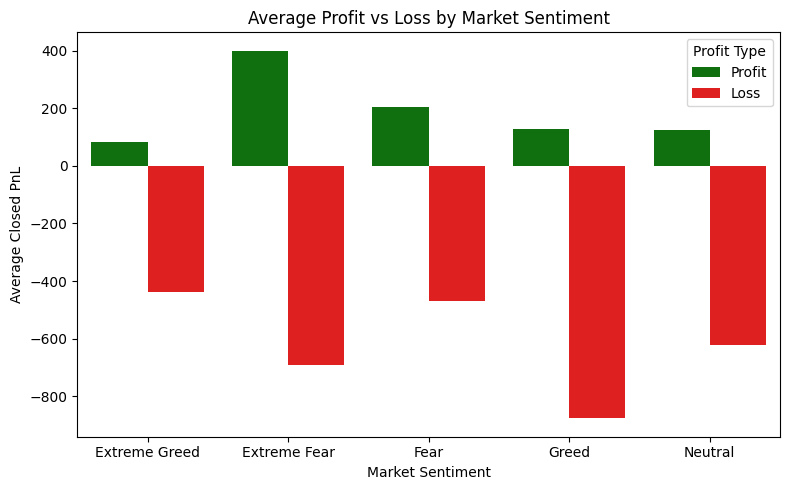

Profit vs Loss plot saved: /content/ds_siddhi/outputs/avg_pnl_profit_loss_by_sentiment.png


/tmp/ipython-input-546865180.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=performance_summary, x='classification', y=volume_col, palette='coolwarm')


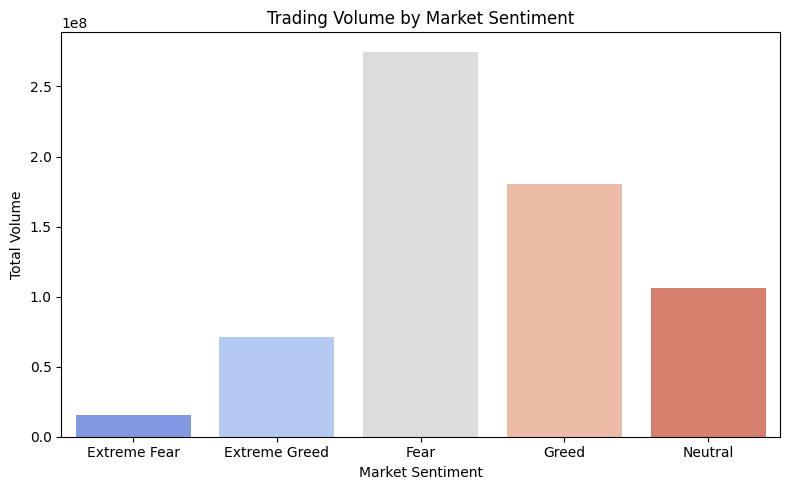

Volume plot saved: /content/ds_siddhi/outputs/volume_by_sentiment.png
Correlation matrix saved: /content/ds_siddhi/csv_files/correlation_matrix.csv

Correlation matrix:
             closed_pnl  size_usd
closed_pnl    1.000000  0.131214
size_usd      0.131214  1.000000

Files saved


In [ ]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from shutil import make_archive

#Create folder structure
root_dir = "/content/ds_siddhi"
csv_dir = os.path.join(root_dir, "csv_files")
output_dir = os.path.join(root_dir, "outputs")
os.makedirs(csv_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)
print("Folder structure created!")

#Load uploaded datasets (ensure files are uploaded to Colab)
sentiment_df = pd.read_csv("/content/fear_greed_index.csv")
trader_df = pd.read_csv("/content/historical_data.csv")

#Standardize column names
trader_df.columns = trader_df.columns.str.strip().str.lower().str.replace(' ', '_')
sentiment_df.columns = sentiment_df.columns.str.strip().str.lower().str.replace(' ', '_')

#Convert date columns
sentiment_df['date'] = pd.to_datetime(sentiment_df['date']).dt.date
trader_df['date'] = pd.to_datetime(trader_df['timestamp_ist'], format='%d-%m-%Y %H:%M').dt.date

#Merge datasets on date
merged_df = pd.merge(trader_df, sentiment_df[['date','classification']], on='date', how='left')
merged_path = os.path.join(csv_dir, "merged_trader_sentiment.csv")
merged_df.to_csv(merged_path, index=False)
print(f"Merged CSV saved: {merged_path}")

#Identify profit and volume columns
if 'closed_pnl' in merged_df.columns:
    profit_col = 'closed_pnl'
elif 'closedpnl' in merged_df.columns:
    profit_col = 'closedpnl'
else:
    raise KeyError("No recognizable profit column in trader data")

if 'size_usd' in merged_df.columns:
    volume_col = 'size_usd'
elif 'size' in merged_df.columns:
    volume_col = 'size'
else:
    raise KeyError("No recognizable volume column in trader data")

#Analysis - Average Profit/Loss, Total Volume by sentiment
merged_df['profit_type'] = merged_df[profit_col].apply(lambda x: 'Profit' if x>=0 else 'Loss')

performance_summary = merged_df.groupby('classification').agg({
    profit_col: 'mean',
    volume_col: 'sum'
}).reset_index()

# Save performance summary CSV
performance_path = os.path.join(csv_dir, "performance_summary.csv")
performance_summary.to_csv(performance_path, index=False)
print(f"Performance summary CSV saved: {performance_path}")

#Visualizations
# Avg Profit/Loss by Sentiment with Profit vs Loss distinction
plt.figure(figsize=(8,5))
sns.barplot(
    data=merged_df,
    x='classification',
    y=profit_col,
    hue='profit_type',
    estimator=np.mean,
    ci=None,
    palette={'Profit':'green', 'Loss':'red'}
)
plt.title("Average Profit vs Loss by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Average Closed PnL")
plt.legend(title='Profit Type')
plt.tight_layout()
pnl_plot_path = os.path.join(output_dir, "avg_pnl_profit_loss_by_sentiment.png")
plt.savefig(pnl_plot_path)
plt.show()
plt.close()
print(f"Profit vs Loss plot saved: {pnl_plot_path}")

#Total Volume by sentiment
plt.figure(figsize=(8,5))
sns.barplot(data=performance_summary, x='classification', y=volume_col, palette='coolwarm')
plt.title("Trading Volume by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Total Volume")
plt.tight_layout()
vol_plot_path = os.path.join(output_dir, "volume_by_sentiment.png")
plt.savefig(vol_plot_path)
plt.show()
plt.close()
print(f"Volume plot saved: {vol_plot_path}")

#Correlation matrix
numeric_cols = [profit_col, volume_col]
for col in ['value', 'leverage']:
    if col in merged_df.columns:
        numeric_cols.append(col)

if len(numeric_cols) > 1:
    correlation = merged_df[numeric_cols].corr()
    corr_path = os.path.join(csv_dir, "correlation_matrix.csv")
    correlation.to_csv(corr_path)
    print(f"Correlation matrix saved: {corr_path}")
    print("\nCorrelation matrix:\n", correlation)

#Zip folder for download
make_archive(root_dir, 'zip', root_dir)
print("\nFiles saved")
